# TP : Construire un premier CNN sur Fashion-MNIST

Ce TP vous amène à mettre en place l'ensemble du pipeline d'un réseau convolutionnel simple appliqué à Fashion-MNIST : exploration des données, vectorisation, architecture CNN, apprentissage supervisé et analyse des performances. 


### Préparer l'environnement d'apprentissage convolutionnel

Importez toutes les bibliothèques nécessaires : `matplotlib.pyplot` pour la visualisation, `torch` et `torch.nn` pour la construction du modèle, `torchvision.datasets` pour accéder à Fashion-MNIST, `torch.utils.data` (incluant `Dataset`, `DataLoader` et `random_split`) pour structurer les jeux de données, ainsi que `numpy`, `tqdm` et les métriques de `sklearn` utiles au suivi des performances.

In [83]:
import matplotlib.pyplot as plt
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np  
from torch.utils.data import random_split
from tqdm import tqdm
from sklearn.metrics import classification_report
import os

### Charger le corpus Fashion-MNIST

Utilisez `datasets.FashionMNIST` pour télécharger la partie entraînement (`train=True`) du jeu de données dans le répertoire local, puis conservez l'objet `full_mnist` qui servira de base à toutes les manipulations ultérieures.

In [84]:
data_dir = './data/' ## mettez le votre
full_mnist = datasets.FashionMNIST(data_dir,train=True,download=True)

### Examiner visuellement un exemple du dataset

Implémentez la fonction `show_fmnist_image(dataset, idx)` qui doit :

- Extraire l'image et l'étiquette associées à l'indice `idx` du dataset fourni.
- Afficher l'image en niveaux de gris (dans `plt.show` -> `cmap='gray'`) avec comme titre le nom de la classe correspondante (utilisez `dataset.classes[label]`).
- Afficher la forme du tenseur image, la valeur minimale et maximale des pixels, ainsi que l'identifiant numérique et le nom de la classe.
- Tester la fonction sur un indice donné (par exemple `24300`) pour illustrer son fonctionnement.


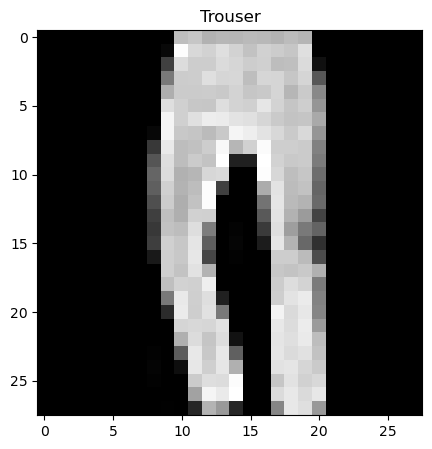

Image shape : torch.Size([28, 28])
Min value: 0
Max value: 255


In [85]:
def show_fmnist_image(dataset, idx):
    img = dataset.data[idx]
    label = dataset.targets[idx].item()
    label_txt = dataset.classes[label]
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(label_txt)
    plt.show()
    print("Image shape :", img.shape)
    print("Min value:", img.min().item())
    print("Max value:", img.max().item())

show_fmnist_image(full_mnist, 24300)

### Inventorier les catégories disponibles

Affichez le nombre total de classes contenues dans `full_mnist.classes`, puis parcourez cette liste pour présenter chaque intitulé en l'associant à son identifiant numérique.


In [86]:
for i,label in enumerate(full_mnist.classes):
    print(f"{i}: {label}")

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


### Séparer apprentissage et validation

Calculez une partition 80 % / 20 % de `full_mnist`, puis utilisez `random_split` pour générer les sous-ensembles `train_mnist` et `val_mnist` qui serviront respectivement à l'entraînement et à la validation.


In [87]:
train_len = int(0.8 * len(full_mnist))
val_len = int(0.2* len(full_mnist))
train_mnist, val_mnist =random_split(full_mnist,(train_len,val_len))

print("Number of training examples:", len(train_mnist))
print("Number of validation examples:", len(val_mnist))

Number of training examples: 48000
Number of validation examples: 12000


### Structurer les données pour PyTorch

Définissez la classe `FMNIST_Dataset(images, labels)` héritant de `Dataset` :
- Dans `__init__(self, images, labels)`, convertissez les images en float, normalisez-les entre 0 et 1 (division par 255.0), puis reformatez-les en tenseurs de forme `(N, 1, 28, 28)` pour PyTorch.
- Implémentez `__len__(self)` pour retourner la cardinalité.
- Implémentez `__getitem__(self, index)` pour fournir le couple `(image, label)` indexé.


In [88]:
class FMNIST_Dataset(Dataset):
    def __init__(self,images,labels) -> None:
        super().__init__()
        self.X = images.view(images.shape[0], -1).float() / 255.0
        self.Y = labels
        self.len = len(images)
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]

### Instancier les partitions d'entraînement et de validation

Sélectionnez les tenseurs d'images et d'étiquettes correspondant aux indices de `train_mnist` et `val_mnist`, puis créez deux instances de `FMNIST_Dataset` dédiées à l'entraînement et à la validation.


In [89]:
train_images = full_mnist.data[train_mnist.indices]
train_labels =full_mnist.targets[train_mnist.indices]
val_images = full_mnist.data[val_mnist.indices]
val_labels = full_mnist.targets[val_mnist.indices]

train_dataset = FMNIST_Dataset(train_images, train_labels)
val_dataset = FMNIST_Dataset(val_images, val_labels)

### Préparer les DataLoaders mini-batch

- Fixez un `batch_size` adapté (par exemple 32).
- Instanciez les `DataLoader` d'entraînement (`train_loader`) et de validation (`val_loader`).

NB : Activez `shuffle=True` pour le jeu d'entraînement afin de favoriser la généralisation.


In [90]:
batch_size = 32 # A adaper si besoin en fonction de votre machine
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size)

### Sélectionner le dispositif de calcul qu'on va utiliser

- Détecter l’accélérateur disponible dans l’ordre de priorité: `CUDA` → `MPS` (Mac Apple Silicon) → `CPU` et le stocker dans `device`.
- Afficher le device retenu: `print("Using device:", device)`.


In [91]:
device=torch.accelerator.current_accelerator() if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Concevoir l'architecture CNN

Implémentez la classe `SimpleCNNModel(input_size=28*28, num_classes)` dérivée de `nn.Module` :

- Dans `__init__`, définissez une séquence composée de deux blocs convolution–max pooling suivis de couches linéaires :  
    - Premier bloc : `nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)`, suivi de `nn.MaxPool2d(kernel_size=2, stride=2)` et `nn.ReLU()`
    - Second bloc : `nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)`, suivi de `nn.MaxPool2d(kernel_size=2, stride=2)` et `nn.ReLU()`
    - Aplatissement avec `nn.Flatten()`
    - Couche linéaire `nn.Linear(3200, 256)`, activation `nn.ReLU()`
    - Couche de sortie `nn.Linear(256, num_classes)`

- Implémentez `forward(self, x)` pour appliquer ce pipeline à un lot d'images.

Placez le modèle sur le device.


In [92]:
class SimpleCNNModel(nn.Module):
    def __init__(self,kernel_size=(3,3)) -> None:
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=kernel_size,stride=(1,1)),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=kernel_size,stride=(1,1)),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=3200, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10, bias=True)
        )
        
    def forward(self,x):
        xb = x.view(-1, 1, 28, 28)
        return self.model(xb)

model = SimpleCNNModel()
model = model.to(device)
display(model)

SimpleCNNModel(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3200, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=10, bias=True)
  )
)

### Évaluer le modèle sur un DataLoader

Rédigez la fonction `evaluate_dataloader(model, dataloader, loss_fn, device)` qui calcule la perte moyenne et l’exactitude globale d’un modèle sur tout un `DataLoader`.

NB : Utilisez `tqdm` pour afficher la progression.

In [93]:
def evaluate_dataloader(model, dataloader, loss_fn, device):
   
   total_loss = 0.0
   total_correct = 0
   total_samples = 0
   with torch.no_grad():
      loop = tqdm(enumerate(dataloader), total=len(dataloader),desc="Validation") 
      for i, (x, y) in loop:
         x = x.to(device)
         y = y.to(device)
         preds = model(x)
         loss = loss_fn(preds, y)
         total_loss += loss.item() * x.size(0)
         _, predicted = torch.max(preds, 1)
         total_correct += (predicted == y).sum().item()
         total_samples += y.size(0)
   avg_loss = total_loss / total_samples
   avg_acc = total_correct / total_samples
   return avg_loss, avg_acc

# exemple d'utilisation sur le jeu de validation et le modèle pas encore entraîné
loss_fn = nn.CrossEntropyLoss() 
val_acc, val_loss = evaluate_dataloader(model, val_loader, loss_fn, device)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

Validation:   1%|          | 3/375 [00:00<00:16, 22.69it/s]

Validation: 100%|██████████| 375/375 [00:14<00:00, 25.99it/s]

Validation Accuracy: 2.3041, Validation Loss: 0.1004


### Conduire la boucle d'entraînement supervisé
- Instanciez la perte avec `loss_fn = nn.CrossEntropyLoss()`.
- Créez l’optimiseur avec `optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)`.
- Initialisez les listes de suivi qui serviront plus tard à afficher les courbes d'apprentissage : `train_losses`, `train_accuracies`, `val_losses`, `val_accuracies`.

- Boucle sur `epochs` époques :
    - Passez le modèle en mode entraînement (`model.train()`).
    - Parcourez `train_loader` avec `tqdm`.
    - Calculez les prédictions et la perte.
    - Rétropropagez (`loss.backward()`).
    - Mettez à jour les poids (`optimizer.step()`).
    - Réinitialisez les gradients (`optimizer.zero_grad()`).
- À la fin de chaque époque :
    - Évaluez sur `train_loader` et `val_loader` via `evaluate_dataloader`.
    - Stockez les métriques dans `train_accuracies`, `train_losses`, `val_accuracies`, `val_losses`.


In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

In [95]:
epochs = 5
for epoch in range(epochs):

    model.train()
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")    
    
    for i, batch in loop:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # batch accuracy
        _, predicted = torch.max(preds, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)

        loop.set_postfix({'batch_loss': batch_loss.item(), 'batch_acc': accuracy})

    model.eval()
    train_loss, train_accuracy = evaluate_dataloader(model, train_loader, loss_fn, device)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f"train_loss={train_loss:.4f}, train_acc={train_accuracy:.4f}")

    val_loss, val_accuracy = evaluate_dataloader(model, val_loader, loss_fn, device)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    print(f"val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}")
    
    print("-" * 50)
      

Validation: 100%|██████████| 1500/1500 [00:56<00:00, 26.67it/s]


train_loss=0.3208, train_acc=0.8813


Validation: 100%|██████████| 375/375 [00:14<00:00, 25.34it/s]


val_loss=0.3345, val_acc=0.8762
--------------------------------------------------


Validation: 100%|██████████| 1500/1500 [00:38<00:00, 39.12it/s]


train_loss=0.2436, train_acc=0.9097


Validation: 100%|██████████| 375/375 [00:08<00:00, 42.97it/s]


val_loss=0.2724, val_acc=0.9035
--------------------------------------------------


Validation: 100%|██████████| 1500/1500 [00:36<00:00, 40.78it/s]


train_loss=0.1932, train_acc=0.9291


Validation: 100%|██████████| 375/375 [00:09<00:00, 40.72it/s]


val_loss=0.2326, val_acc=0.9157
--------------------------------------------------


Validation: 100%|██████████| 1500/1500 [00:46<00:00, 32.20it/s]


train_loss=0.1819, train_acc=0.9300


Validation: 100%|██████████| 375/375 [00:09<00:00, 37.53it/s]


val_loss=0.2424, val_acc=0.9093
--------------------------------------------------


Validation: 100%|██████████| 1500/1500 [01:07<00:00, 22.14it/s]


train_loss=0.1451, train_acc=0.9468


Validation: 100%|██████████| 375/375 [00:17<00:00, 21.98it/s]

val_loss=0.2308, val_acc=0.9181
--------------------------------------------------


### Visualiser l'évolution des performances

Tracez sur deux sous-graphiques l'évolution des pertes et des exactitudes pour l'entraînement et la validation en fonction des époques, légendez correctement les axes et appliquez `plt.tight_layout()` pour assurer une présentation lisible.

- Utilisez les listes `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies` pour afficher les courbes d'apprentissage.
- Placez la perte (loss) sur le premier sous-graphe et l'exactitude (accuracy) sur le second.
- Ajoutez une légende, des titres et des labels d'axes pour chaque sous-figure.
- Utilisez `plt.tight_layout()` pour éviter le chevauchement des éléments graphiques.


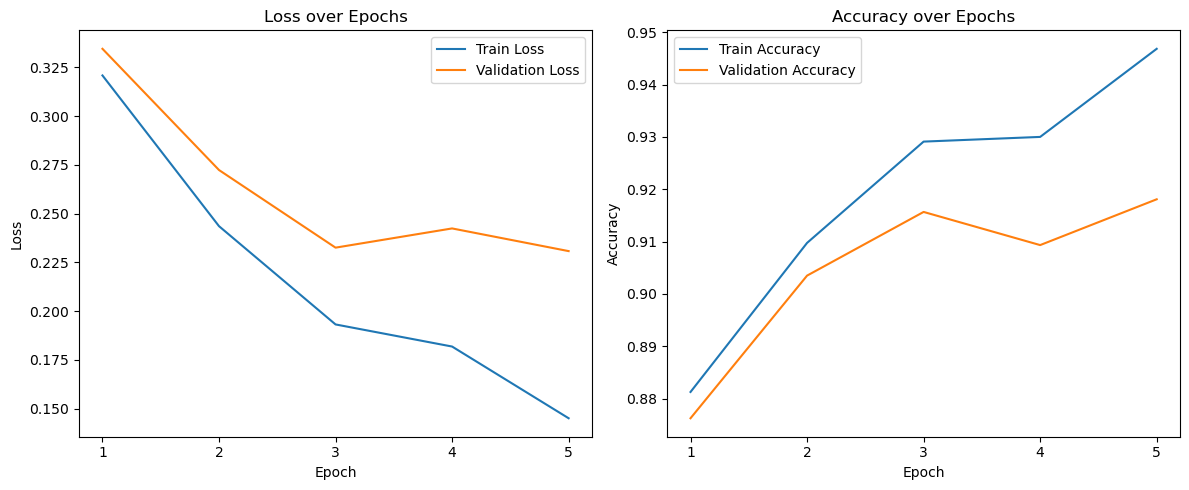

In [96]:
# Visualisation des courbes de perte et d'exactitude

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.xticks(range(1, len(train_losses)+1, 1))
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.xticks(range(1, len(train_losses)+1, 1))
plt.legend()

plt.tight_layout()
plt.show()

### Définir le chemin de sauvegarde du modèle

Indiquez le nom de fichier qui servira à stocker les poids appris du réseau, de sorte à pouvoir réutiliser l'état entraîné ultérieurement.


In [97]:
model_weighths_dir = "./model_weights/" # mettez le votre
model_name = "04_simple_cnn_model.pth"
weights_path = os.path.join(model_weighths_dir, model_name)

# torch.save(model.state_dict(), weights_path) # commenté pour ne pas écraser à chaque exécution

print(f"Model weights saved to {weights_path}")

Model weights saved to ./model_weights/04_simple_cnn_model.pth


### Sauvegarder les poids du modèle entraîné

Préparez l'appel à `torch.save(model.state_dict(), weights_path)` assorti d'un message de confirmation afin de sérialiser les paramètres du modèle ; laissez ces instructions commentées si vous souhaitez éviter l'écriture automatique lors des tests.


In [98]:
torch.save(model.state_dict(), weights_path)
print(f"Model weights saved to {weights_path}")

Model weights saved to ./model_weights/04_simple_cnn_model.pth


### Recharger un modèle sauvegardé

Chargez les poids depuis `filename` en tenant compte du `device`, appliquez-les au modèle puis affichez un message confirmant que l'état entraîné est correctement restauré.


In [99]:
model_load=torch.load(weights_path,weights_only=True)
print(f"Model weights loaded from {weights_path}")

Model weights loaded from ./model_weights/04_simple_cnn_model.pth


### Générer un rapport de classification détaillé

- Implémentez la fonction `report_on_loader(model, dataloader, device, classes)` :
    - Placez le modèle en mode évaluation (`model.eval()`).
    - Collectez les prédictions sur le `dataloader` sans calcul de gradient (`torch.no_grad()`).
    - Rapatriez les étiquettes réelles et prédites sur le CPU.
    - Invoquez `classification_report` en lui passant `classes` afin d'obtenir des métriques par catégorie.


In [100]:
def report_on_loader(model, dataloader, device, classes):
    """Generate a detailed classification report on the given dataloader.
    
    Args:
        model: The trained PyTorch model to evaluate
        dataloader: DataLoader containing the dataset to evaluate on
        device: Device (CPU/CUDA/MPS) where computations will be performed
        classes: List of class names for the classification report
        
    Returns:
        None (prints the classification report)
    """
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print(classification_report(all_labels, all_preds, target_names=classes))

# evaluation sur le train_loader
report_on_loader(model, train_loader, device, full_mnist.classes)

              precision    recall  f1-score   support

 T-shirt/top       0.94      0.89      0.91      4785
     Trouser       1.00      0.99      0.99      4756
    Pullover       0.93      0.89      0.91      4828
       Dress       0.95      0.96      0.95      4795
        Coat       0.88      0.93      0.91      4776
      Sandal       0.99      0.99      0.99      4822
       Shirt       0.83      0.86      0.85      4826
     Sneaker       0.97      0.98      0.98      4786
         Bag       0.99      1.00      1.00      4799
  Ankle boot       0.99      0.97      0.98      4827

    accuracy                           0.95     48000
   macro avg       0.95      0.95      0.95     48000
weighted avg       0.95      0.95      0.95     48000



### Évaluer la généralisation sur la validation

Réutilisez `report_on_loader` sur `val_loader` afin de comparer les métriques de validation à celles de l'entraînement et de contrôler la capacité de généralisation du modèle.


In [101]:
# evaluation sur le val_loader
report_on_loader(model, train_loader, device, full_mnist.classes)

              precision    recall  f1-score   support

 T-shirt/top       0.94      0.89      0.91      4785
     Trouser       1.00      0.99      0.99      4756
    Pullover       0.93      0.89      0.91      4828
       Dress       0.95      0.96      0.95      4795
        Coat       0.88      0.93      0.91      4776
      Sandal       0.99      0.99      0.99      4822
       Shirt       0.83      0.86      0.85      4826
     Sneaker       0.97      0.98      0.98      4786
         Bag       0.99      1.00      1.00      4799
  Ankle boot       0.99      0.97      0.98      4827

    accuracy                           0.95     48000
   macro avg       0.95      0.95      0.95     48000
weighted avg       0.95      0.95      0.95     48000



### Evaluation sur le jeu de test officiel

Téléchargez la portion test de Fashion-MNIST (`train=False`), encapsulez-la dans `FMNIST_Dataset` puis construisez un `DataLoader` (sans mélange) nommé `test_loader`.

Appliquez `report_on_loader` sur `test_loader` pour évaluer le modèle sur des données inédites et analysez les résultats obtenus sur ce jeu de référence pour juger de la robustesse du modèle en situation réelle.


In [102]:
test_data = datasets.FashionMNIST(data_dir,download=True,train=False)
test_mnist = FMNIST_Dataset(test_data.data,test_data.targets)
test_loader =DataLoader(test_mnist,batch_size=batch_size)

report_on_loader(model, test_loader, device, test_data.classes)

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.82      0.85      1000
     Trouser       1.00      0.97      0.99      1000
    Pullover       0.86      0.85      0.85      1000
       Dress       0.91      0.90      0.91      1000
        Coat       0.83      0.88      0.85      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.71      0.75      0.73      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### Visualiser un exemple de la classe "trousers"

Identifiez dans le jeu de test les indices correspondant à la classe `trousers` (étiquette numérique 1) en utilisant une opération de masquage sur `test_data.targets`. 

Extrayez le premier indice correspondant, récupérez l'image associée depuis `test_data.data`, puis affichez-la en niveaux de gris avec `matplotlib` en utilisant le nom de classe approprié comme titre. 

Indiquez également l'indice sélectionné.

Index of a trousers image in the test set: 2


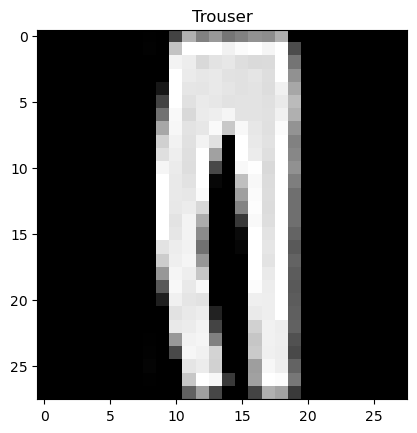

In [103]:

ids_where_trousers = (test_data.targets == 1).nonzero(as_tuple=True)[0]
idx = ids_where_trousers[0].item()
print("Index of a trousers image in the test set:", idx)
img = test_data.data[idx]
plt.imshow(img, cmap='gray')
plt.title(test_data.classes[1])
plt.show()

### Étude de la robustesse aux translations horizontales

Générez une grille de visualisations (`plt.subplots(2, 5)`) présentant 10 versions de l'image précédente, chacune translatée horizontalement de 0 à 9 pixels vers la droite à l'aide de `torch.roll(img, shifts=px, dims=1)`. 

Pour chaque version translatée :
- Normalisez l'image en la convertissant en tenseur flottant (`float()`), en la reformatant en dimensions `(1, 1, 28, 28)` avec `view(-1, 1, 28, 28)` et en divisant par 255.0
- Transférez le tenseur vers le `device` approprié
- Interrogez le modèle avec `model(img_input)` en mode évaluation (sans calcul de gradients via `torch.no_grad()`) et extrayez la classe prédite
- Affichez l’image translatée en niveaux de gris, ajoutez un titre indiquant le décalage appliqué et la classe prédite (par ex. "Shift 3 → Trouser") pour observer l’impact des translations sur la robustesse des prédictions.


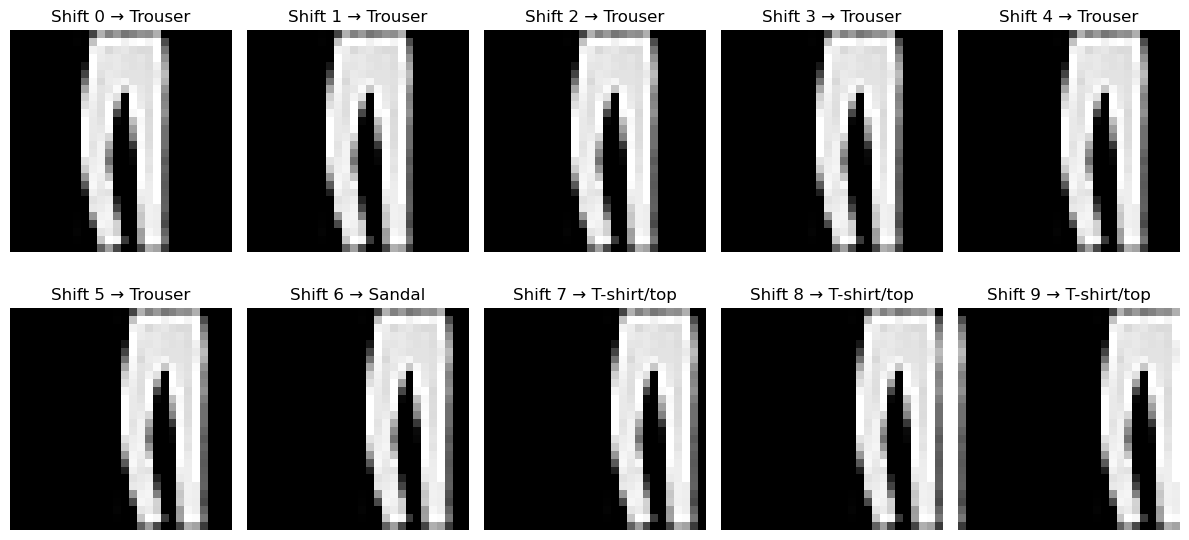

In [104]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for px, ax in zip(range(10), axes.flatten()):
    shifted_img = torch.roll(img, shifts=px, dims=1)
    img_input = shifted_img.float().view(1, -1) / 255.0
    img_input = img_input.to(device)
    with torch.no_grad():
        output = model(img_input)
        pred_label = torch.argmax(output, dim=1).item()
    ax.imshow(shifted_img.cpu(), cmap='gray')
    ax.set_title(f"Shift {px} → {test_data.classes[pred_label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Étudier les paramètres du modèle

Utilisez la fonction `summary` du module `torchsummary` pour afficher un résumé détaillé de l'architecture du modèle. Cette fonction présente :
- La structure des couches du réseau avec leurs dimensions de sortie
- Le nombre de paramètres par couche (entraînables et non entraînables)
- Le nombre total de paramètres du modèle
- La taille mémoire estimée pour les paramètres et les activations


Comparez avec la version sans CNN entrainée précédemment (TD 01).

In [105]:
from torchsummary import summary
summary(model,(28,28,1),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 26, 26]             640
         MaxPool2d-2           [32, 64, 13, 13]               0
              ReLU-3           [32, 64, 13, 13]               0
            Conv2d-4          [32, 128, 11, 11]          73,856
         MaxPool2d-5            [32, 128, 5, 5]               0
              ReLU-6            [32, 128, 5, 5]               0
           Flatten-7                 [32, 3200]               0
            Linear-8                  [32, 256]         819,456
              ReLU-9                  [32, 256]               0
           Linear-10                   [32, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 22.10
Params size (MB): 3.42
Estimated 